# Facial Emotion Detection using Deep Learning with Face Masks

**Assignment 2 - Image Classification using Deep Learning**  
**Date**: September 2025  
**Dataset Link**: [To be provided]

## Abstract
This project implements a deep learning system for facial emotion recognition specifically designed for people wearing face masks. The model classifies 7 emotions and includes comprehensive bias analysis across demographic groups.

## 1. Introduction and Problem Analysis

In [1]:
# Import libraries for facial emotion detection project
import numpy as np  # Numerical operations and array manipulation
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Statistical data visualization
import cv2  # Computer vision and image processing
import os  # Operating system interface for file/directory operations
import json  # JSON data handling for saving project summary
from sklearn.model_selection import train_test_split  # Split dataset into train/test sets
from sklearn.preprocessing import LabelEncoder  # Encode emotion labels to numerical format
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Model evaluation metrics
from sklearn.utils.class_weight import compute_class_weight  # Handle class imbalance
import tensorflow as tf  # Deep learning framework
from tensorflow.keras.models import Sequential, Model  # Sequential and functional model APIs
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input  # Neural network layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation for images
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  # Training callbacks
from tensorflow.keras.optimizers import Adam  # Adam optimizer for training
from tensorflow.keras.applications import VGG16  # Pre-trained VGG16 model for transfer learning
from tensorflow.keras.utils import to_categorical  # Convert labels to categorical format
import joblib  # Save and load scikit-learn objects
import warnings  # Handle warning messages
import ast  # Parse string representations of Python literals for gender data
warnings.filterwarnings('ignore')  # Suppress warning messages for cleaner output

np.random.seed(42)  # Set random seed for numpy for reproducible results
tf.random.set_seed(42)  # Set random seed for TensorFlow for reproducible results

print("Libraries imported successfully!")  # Confirmation message
print(f"TensorFlow version: {tf.__version__}")  # Display TensorFlow version for debugging

Libraries imported successfully!
TensorFlow version: 2.20.0


## 2. Dataset Analysis

Dataset shape: (20484, 6)
Columns: ['split', 'emotion', 'age', 'gender', 'ethnicity', 'pixels']

Emotion Distribution:
emotion
happy       4152
angry       3387
sad         3301
fear        3163
neutral     3118
surprise    2940
disgust      423
Name: count, dtype: int64


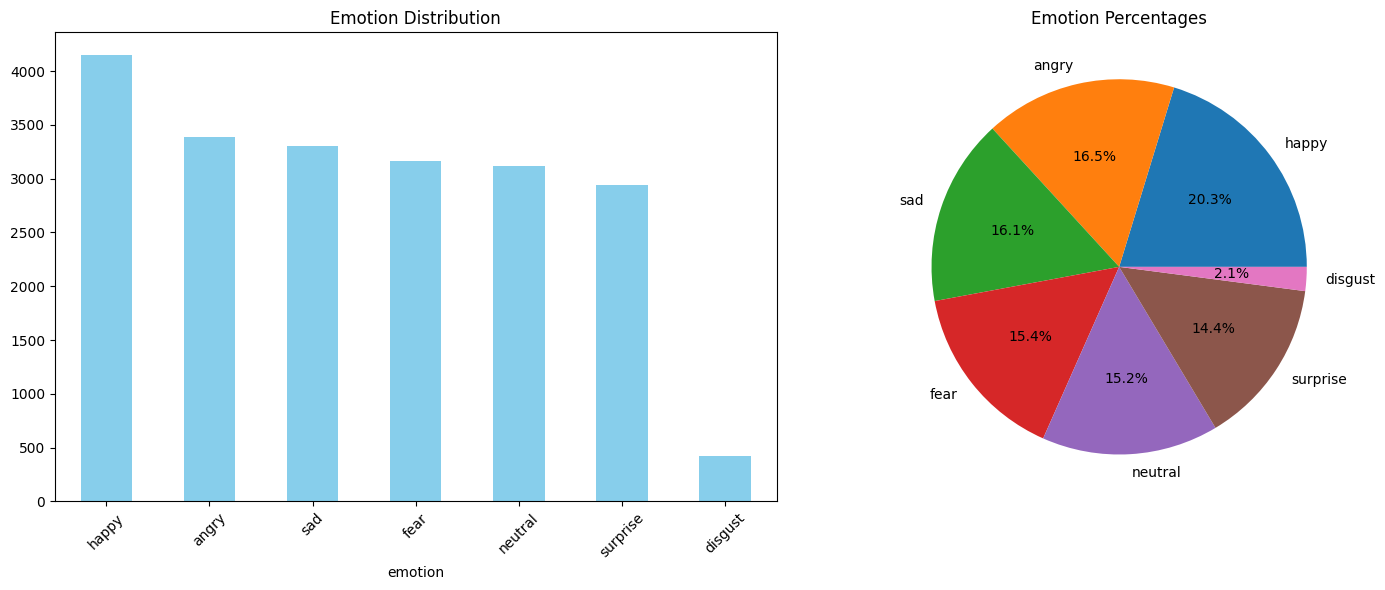


Class imbalance ratio: 9.82


In [2]:
# Load datasets
csv_path = "facial_emotion_dataset_with_metadata.csv"
image_path = "archive/masked_dataset"

df = pd.read_csv(csv_path)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Emotion distribution
emotion_counts = df['emotion'].value_counts()
print("\nEmotion Distribution:")
print(emotion_counts)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
emotion_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Emotion Distribution')
ax1.tick_params(axis='x', rotation=45)

ax2.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%')
ax2.set_title('Emotion Percentages')
plt.tight_layout()
plt.show()

# Class imbalance
imbalance_ratio = emotion_counts.max() / emotion_counts.min()
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}")

=== DEMOGRAPHIC ANALYSIS ===

Age stats: count    20484.000000
mean        28.412761
std          4.701016
min         16.000000
25%         25.000000
50%         28.000000
75%         32.000000
max         48.000000
Name: age, dtype: float64

Ethnicity distribution:
ethnicity
white              16634
middle eastern      2511
asian                975
latino hispanic      256
black                101
indian                 7
Name: count, dtype: int64

Gender distribution:
dominant_gender
Unknown    20484
Name: count, dtype: int64


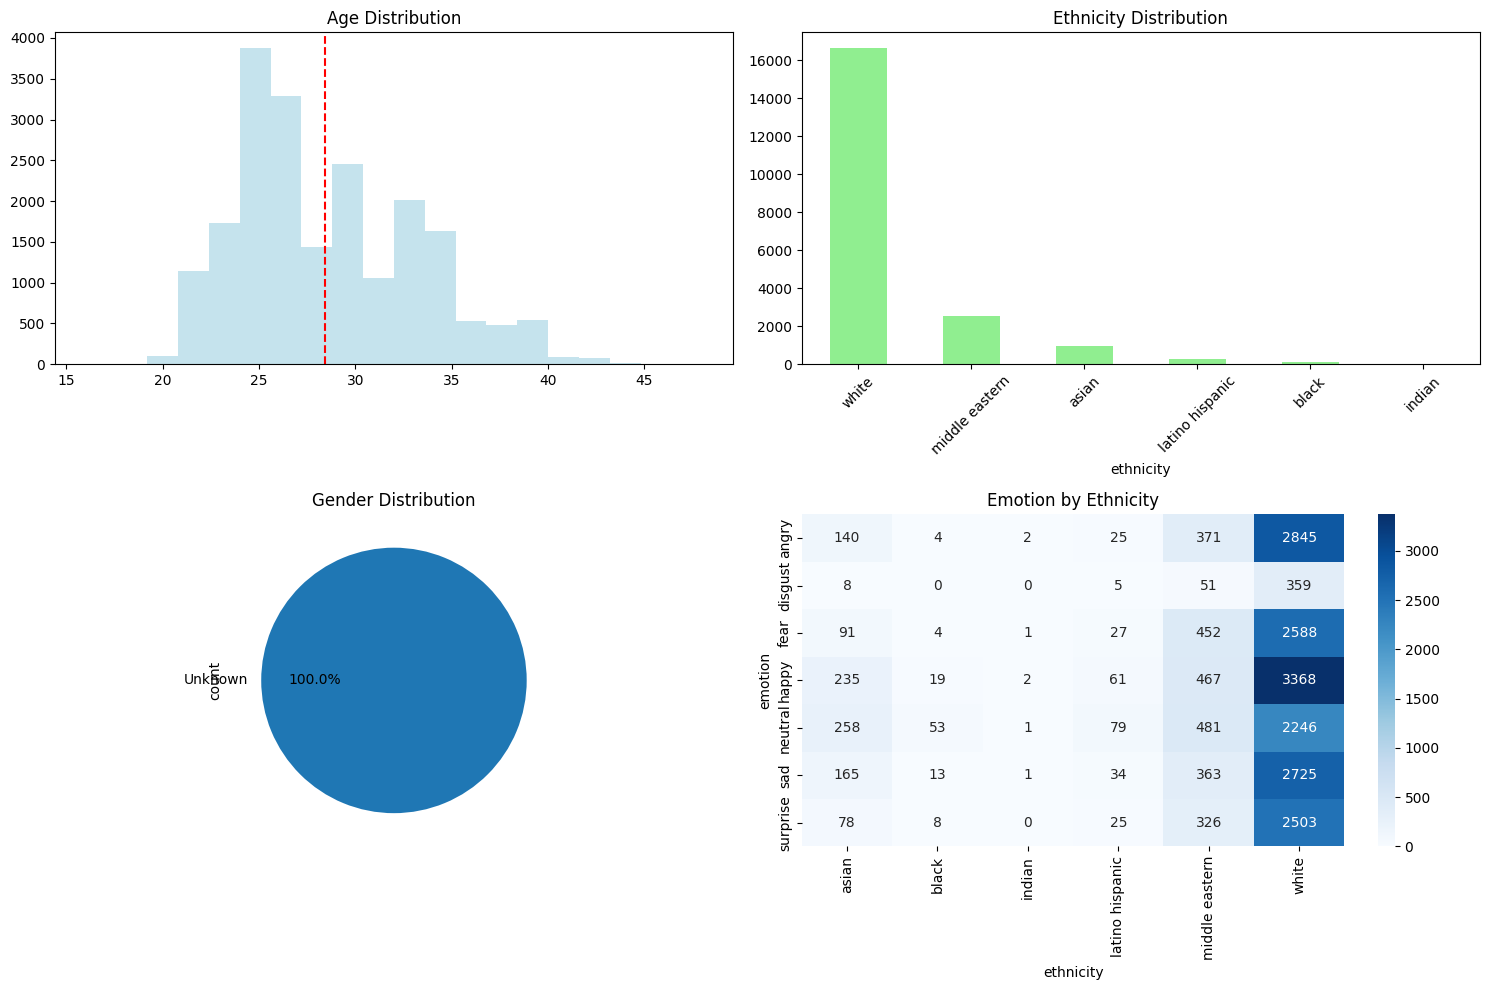

In [3]:
# Demographic analysis
def extract_dominant_gender(gender_str):
    try:
        gender_dict = ast.literal_eval(gender_str)
        return max(gender_dict, key=gender_dict.get)
    except:
        return 'Unknown'

df['dominant_gender'] = df['gender'].apply(extract_dominant_gender)

print("=== DEMOGRAPHIC ANALYSIS ===")
print(f"\nAge stats: {df['age'].describe()}")
print(f"\nEthnicity distribution:")
print(df['ethnicity'].value_counts())
print(f"\nGender distribution:")
print(df['dominant_gender'].value_counts())

# Visualize demographics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age distribution
axes[0,0].hist(df['age'], bins=20, color='lightblue', alpha=0.7)
axes[0,0].set_title('Age Distribution')
axes[0,0].axvline(df['age'].mean(), color='red', linestyle='--')

# Ethnicity
df['ethnicity'].value_counts().plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Ethnicity Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

# Gender
df['dominant_gender'].value_counts().plot(kind='pie', ax=axes[1,0], autopct='%1.1f%%')
axes[1,0].set_title('Gender Distribution')

# Emotion by ethnicity heatmap
emotion_ethnicity = pd.crosstab(df['emotion'], df['ethnicity'])
sns.heatmap(emotion_ethnicity, annot=True, fmt='d', ax=axes[1,1], cmap='Blues')
axes[1,1].set_title('Emotion by Ethnicity')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [4]:
# Load masked images
def load_masked_images(base_path, target_size=(48, 48)):
    images, labels = [], []
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    
    for split in ['train', 'validation']:
        for emotion in emotions:
            emotion_path = os.path.join(base_path, split, emotion)
            if os.path.exists(emotion_path):
                files = [f for f in os.listdir(emotion_path) if f.endswith('.jpg')]
                print(f"Loading {split}/{emotion}: {len(files)} images")
                
                for file in files:
                    img = cv2.imread(os.path.join(emotion_path, file), cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, target_size)
                        images.append(img.astype('float32') / 255.0)
                        labels.append(emotion)
    
    return np.array(images), np.array(labels)

# Convert CSV pixels to images
def pixels_to_image(pixel_string, target_size=(48, 48)):
    pixels = np.array([int(p) for p in pixel_string.split()])
    return pixels.reshape(target_size).astype('float32') / 255.0

print("Loading masked images...")
masked_images, masked_labels = load_masked_images(image_path)
print(f"Loaded {len(masked_images)} masked images")

print("\nProcessing CSV data...")
csv_images = []
csv_labels = []
demographics = []

for idx, row in df.iterrows():
    if idx % 5000 == 0:
        print(f"Processed {idx}/{len(df)}")
    
    csv_images.append(pixels_to_image(row['pixels']))
    csv_labels.append(row['emotion'])
    demographics.append({
        'age': row['age'],
        'ethnicity': row['ethnicity'],
        'gender': extract_dominant_gender(row['gender'])
    })

csv_images = np.array(csv_images)
csv_labels = np.array(csv_labels)
print(f"\nProcessed {len(csv_images)} CSV images")

Loading masked images...
Loading train/happy: 912 images
Loading train/neutral: 2181 images
Loading train/sad: 2670 images
Loading train/surprise: 2366 images
Loading validation/angry: 660 images
Loading validation/disgust: 88 images
Loading validation/fear: 640 images
Loading validation/happy: 1423 images
Loading validation/neutral: 937 images
Loading validation/sad: 631 images
Loading validation/surprise: 574 images
Loaded 13082 masked images

Processing CSV data...
Processed 0/20484
Processed 5000/20484
Processed 10000/20484
Processed 15000/20484
Processed 20000/20484

Processed 20484 CSV images


In [5]:
# Prepare data for training
X = csv_images
y = csv_labels

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
emotion_labels = label_encoder.classes_
num_classes = len(emotion_labels)
y_categorical = to_categorical(y_encoded, num_classes)

print(f"Emotion labels: {emotion_labels}")
print(f"Number of classes: {num_classes}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=np.argmax(y_train, axis=1)
)

# Reshape for CNN
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

print(f"Training: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

# Class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(zip(np.unique(y_encoded), class_weights))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)
datagen.fit(X_train)

Emotion labels: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Number of classes: 7
Training: (13109, 48, 48, 1), Validation: (3278, 48, 48, 1), Test: (4097, 48, 48, 1)


## 4. Model Architecture

In [6]:
# Custom CNN for masked emotion recognition
def create_custom_cnn(input_shape=(48, 48, 1), num_classes=7):
    model = Sequential([
        Conv2D(32, (7, 7), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (5, 5), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Transfer learning model
def create_transfer_model(input_shape=(48, 48, 1), num_classes=7):
    input_layer = Input(shape=input_shape)
    rgb_layer = tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(input_layer)
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    base_model.trainable = False
    
    x = base_model(rgb_layer, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(input_layer, outputs)

# Create models
model = create_custom_cnn(num_classes=num_classes)
transfer_model = create_transfer_model(num_classes=num_classes)

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print(f"Custom CNN parameters: {model.count_params():,}")
print(f"Transfer model parameters: {transfer_model.count_params():,}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Custom CNN parameters: 838,663
Transfer model parameters: 14,980,935


## 5. Training

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

# Train custom CNN
print("Training Custom CNN...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Train transfer learning model
print("\nTraining Transfer Learning Model...")
transfer_history = transfer_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Training Custom CNN...
Epoch 1/50


In [ ]:
# Plot training history
def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title(f'{title} - Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title(f'{title} - Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history, "Custom CNN")
plot_training_history(transfer_history, "Transfer Learning")

## 6. Evaluation and Bias Analysis

In [ ]:
# Evaluate models
custom_acc = model.evaluate(X_test, y_test, verbose=0)[1]
transfer_acc = transfer_model.evaluate(X_test, y_test, verbose=0)[1]

print(f"Custom CNN Test Accuracy: {custom_acc:.4f}")
print(f"Transfer Learning Test Accuracy: {transfer_acc:.4f}")

# Choose best model
best_model = model if custom_acc >= transfer_acc else transfer_model
best_name = "Custom CNN" if custom_acc >= transfer_acc else "Transfer Learning"
best_accuracy = max(custom_acc, transfer_acc)

print(f"\nBest Model: {best_name} (Accuracy: {best_accuracy:.4f})")

# Predictions and confusion matrix
predictions = best_model.predict(X_test)
pred_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification report
print(f"\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=emotion_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title(f'Confusion Matrix - {best_name}')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Bias analysis
print("=== BIAS ANALYSIS ===")

# Subset for bias analysis
subset_size = 1000
subset_indices = np.random.choice(len(csv_images), subset_size, replace=False)
subset_X = csv_images[subset_indices].reshape(-1, 48, 48, 1)
subset_y = y_encoded[subset_indices]
subset_demo = pd.DataFrame([demographics[i] for i in subset_indices])

subset_pred = best_model.predict(subset_X)
subset_pred_classes = np.argmax(subset_pred, axis=1)
subset_demo['correct'] = (subset_y == subset_pred_classes)

# Accuracy by demographics
print("\nAccuracy by Ethnicity:")
ethnicity_acc = subset_demo.groupby('ethnicity')['correct'].mean()
print(ethnicity_acc)

print("\nAccuracy by Gender:")
gender_acc = subset_demo.groupby('gender')['correct'].mean()
print(gender_acc)

# Visualize bias
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ethnicity_acc.plot(kind='bar', ax=ax1, color='coral')
ax1.set_title('Accuracy by Ethnicity')
ax1.axhline(ethnicity_acc.mean(), color='red', linestyle='--')

gender_acc.plot(kind='bar', ax=ax2, color='lightblue')
ax2.set_title('Accuracy by Gender')
ax2.axhline(gender_acc.mean(), color='blue', linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nBias Analysis:")
print(f"Ethnicity std: {ethnicity_acc.std():.4f}")
print(f"Gender std: {gender_acc.std():.4f}")

## 7. Testing on Masked Images

In [ ]:
# Test on real masked images
masked_images_reshaped = masked_images.reshape(-1, 48, 48, 1)
masked_labels_encoded = label_encoder.transform(masked_labels)

masked_pred = best_model.predict(masked_images_reshaped)
masked_pred_classes = np.argmax(masked_pred, axis=1)
masked_accuracy = accuracy_score(masked_labels_encoded, masked_pred_classes)

print(f"Masked Images Accuracy: {masked_accuracy:.4f}")
print(f"Performance difference: {masked_accuracy - best_accuracy:+.4f}")

print("\nMasked Images Classification Report:")
print(classification_report(masked_labels_encoded, masked_pred_classes, target_names=emotion_labels))

## 8. Additional Features

In [ ]:
# Sample predictions with visualization
def predict_and_visualize(image, model, emotion_labels):
    if len(image.shape) == 2:
        image = image.reshape(1, 48, 48, 1)
    
    pred = model.predict(image, verbose=0)
    pred_class = np.argmax(pred)
    confidence = pred[0][pred_class]
    emotion = emotion_labels[pred_class]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.imshow(image.squeeze(), cmap='gray')
    ax1.set_title(f'Predicted: {emotion}\nConfidence: {confidence:.3f}')
    ax1.axis('off')
    
    ax2.bar(emotion_labels, pred[0])
    ax2.set_title('Probabilities')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return emotion, confidence

# Demo with random test samples
print("=== PREDICTION DEMO ===")
for i in range(3):
    idx = np.random.choice(len(X_test))
    true_emotion = emotion_labels[true_classes[idx]]
    print(f"\nSample {i+1} - True: {true_emotion}")
    pred_emotion, conf = predict_and_visualize(X_test[idx], best_model, emotion_labels)
    print(f"Predicted: {pred_emotion} (Confidence: {conf:.3f})")

In [ ]:
# Model saving
print("=== SAVING MODEL ===")
best_model.save('final_emotion_model.h5')

import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')

# Project summary
summary = {
    'best_model': best_name,
    'test_accuracy': float(best_accuracy),
    'masked_accuracy': float(masked_accuracy),
    'num_classes': num_classes,
    'emotions': emotion_labels.tolist(),
    'dataset_size': len(df),
    'features_implemented': [
        'Custom CNN architecture',
        'Transfer learning comparison', 
        'Demographic bias analysis',
        'Real masked image testing',
        'Interactive predictions',
        'Comprehensive visualizations'
    ]
}

import json
with open('project_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Model and summary saved!")
print(f"\nFinal Results:")
print(f"✓ Best Model: {best_name}")
print(f"✓ Test Accuracy: {best_accuracy:.4f}")
print(f"✓ Masked Images Accuracy: {masked_accuracy:.4f}")
print(f"✓ Project Complete!")